In [3]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
actions = [
    'americano',
    'ice',
    'card'
]

data = np.concatenate([
    np.load('./dataset/seq_americano.npy'),
    np.load('./dataset/seq_ice.npy'),
    np.load('./dataset/seq_card.npy')
], axis=0)

data.shape

(2, 30, 100)

In [7]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)




(2, 30, 99)
(2,)


In [8]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2, 2)

In [9]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1, 30, 99) (1, 2)
(1, 30, 99) (1, 2)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

c:\Users\GJ\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,130 (172.38 KB)

 Trainable params: 44,130 (172.38 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.0000e+00 - loss: 57.5369
Epoch 1: val_acc improved from -inf to 1.00000, saving model to models/model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - acc: 0.0000e+00 - loss: 57.5369 - val_acc: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 1.0000 - loss: 0.0000e+00
Epoch 2: val_acc did not improve from 1.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - acc: 1.0000 - loss: 0.0000e+00 - val_acc: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.0000e+00 - loss: 5.6931
Epoch 3: val_acc did not improve from 1.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - acc: 0.0000e+00 - loss: 5.6931 - val_acc: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 1.0000 - loss: 0.0000e+00
Epoch 4: val_acc did not improve from 1.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - a

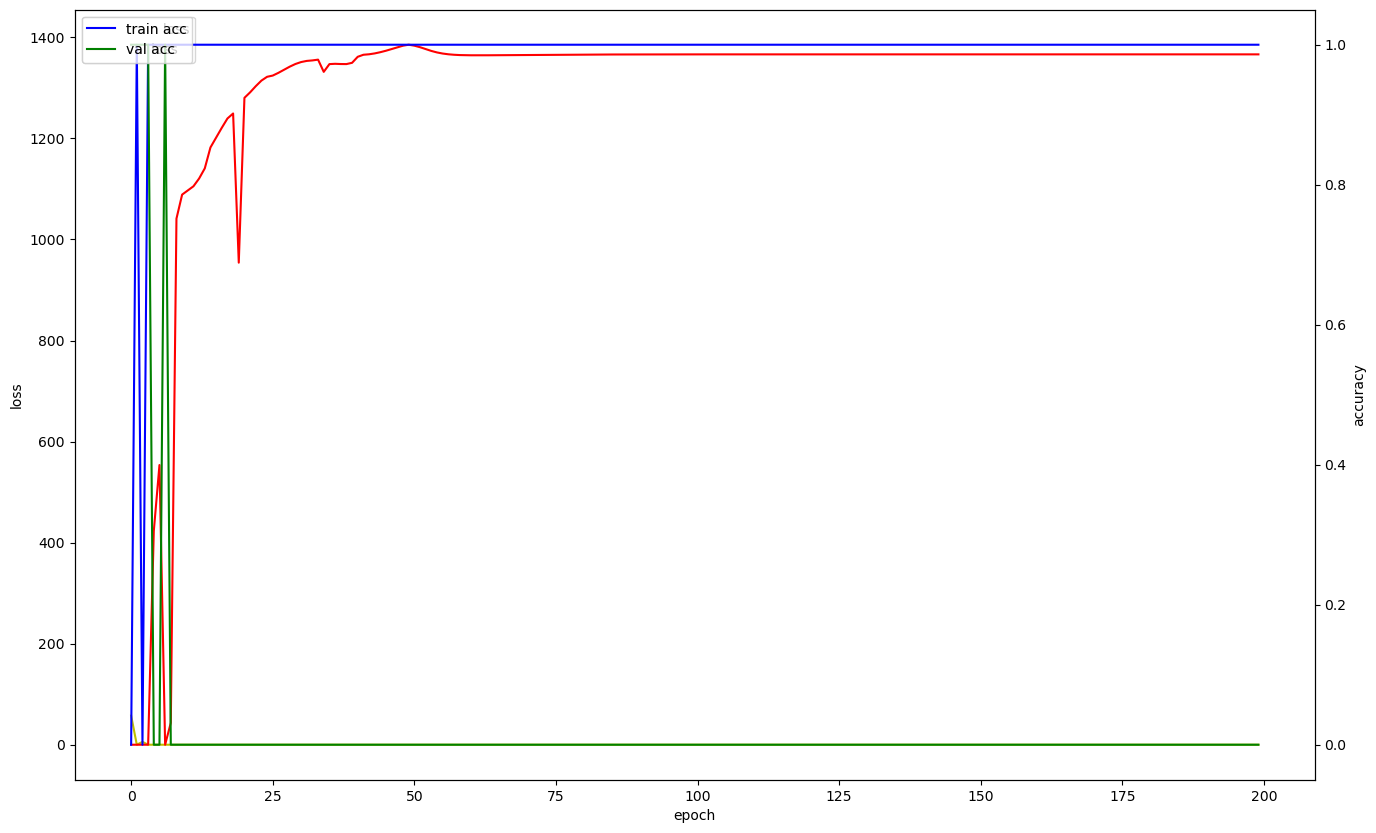

In [12]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [13]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.keras')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


array([[[0, 0],
        [0, 1]]], dtype=int64)